<a href="https://colab.research.google.com/github/lourencocavalcante/Neurocomputacao/blob/main/CAP351_Projeto_01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" align="middle">](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 500 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


---


# **CAP-351 Neurocomputação**

**Professor:**

* Dr. Marcos Goncalves Quiles

**Aluno:**
* Lourenço José Cavalcante Neto

# PROPOSTA DE PROJETO 1:

# REDE MLP:: Multi-layer Perceptron (MLP)

1. Selecionar dois datasets (não triviais)

  * Um dataset para classificação
  * Um dataset para regressão
  * Separar em treino/validação/teste

2. Treinar modelos MLP para os dois problemas

3. Considerar:
  * Diferentes topologias (>=5 topologias, variar número de
camadas)
  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  * Avaliar o impacto do uso do Momentum
  * Avaliar o impacto do uso da regularização (i.e. L2)

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resultados

In [5]:
import pandas as pd

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
import datetime
print(tf.__version__)

2.8.2


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Dataset**

Importando os dados do **disdrômetro RD80 (Joss**)


In [435]:
#CRIANDO O DATAFRAMES
#Dados do disdrômetro RD80. Chamado comumente de Joss. 
#Este equipamento mede a distribuição das gotas de chuva que chegam à superfície.
df_rd80_joss = pd.read_table('/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/JWD_campina_report_RZLwcDmDtNdrop_b2.1_report.txt',header=None,delim_whitespace=True)


In [436]:
print('Tamanho do dataset: ',df_rd80_joss.shape[0], ', quantiade de atributos: ', df_rd80_joss.shape[1])
df_rd80_joss.head()

Tamanho do dataset:  315420 , quantiade de atributos:  31


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,2020.0,3.0,17.0,13.0,52.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020.0,3.0,17.0,13.0,53.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020.0,3.0,17.0,13.0,54.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020.0,3.0,17.0,13.0,55.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020.0,3.0,17.0,13.0,56.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [437]:
#Os Dataframes estão sem título nas colunas. Vamos adicioná-las.

df_rd80_joss.columns = ['Ano (YYYY)', 'Mes', 'dia', 'H', 'M', 'S','Rain Intensity (mm/h)', 'radar reflectivity (1/mm6m3)','Liquid watercontent (g/m3)',
'Mean weight diameter(mm)', 'Time integration (s)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)']


In [438]:
#Modificanto o tipo de dado das colunas referentes a Data e Horário para Inteiro
df_rd80_joss[['Ano (YYYY)', 'Mes', 'dia', 'H', 'M', 'S']] = df_rd80_joss[['Ano (YYYY)', 'Mes', 'dia', 'H', 'M', 'S']].astype(int)
df_rd80_joss['Rain Intensity (mm/h)'] = df_rd80_joss['Rain Intensity (mm/h)'].astype(float)

In [ ]:
cont = df_rd80_joss.shape[0]
for index, row in df_rd80_joss.iterrows():
  #ano = '20' + str(int(row['Ano (YYYY)']))
  ano = str(int(row['Ano (YYYY)']))
  mes = '%02d' % int(row['Mes'])
  dia = '%02d' % int(row['dia'])
  h = '%02d' % int(row['H'])
  m = '%02d' % int(row['M'])
  s = '%02d' % int(row['S'])
    

  #print(mes)
  df_rd80_joss.loc[index, 'Data'] = str(ano) + '-' + str(mes) + '-'+ str(dia)
  df_rd80_joss.loc[index, 'Hora'] = str(h) + ':' + str(m) + ':'+ str(s)
  cont = cont - 1
  print(cont)

In [439]:
df_rd80_joss.head()

,Ano (YYYY),Mes,dia,H,M,S,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),...,N(D),N(D),N(D),N(D),N(D),N(D),N(D),N(D),N(D),N(D)
0,2020,3,17,13,52,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020,3,17,13,53,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020,3,17,13,54,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020,3,17,13,55,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020,3,17,13,56,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_rd80_joss['Datetime'] = df_rd80_joss[['dia','Mes','Ano (YYYY)', 'H', 'M', 'S']].apply(lambda row:
                    datetime.datetime(year=row['Ano (YYYY)'], month=row['Mes'],day=row['dia'], hour=row['H'], minute=row["M"], second=row["S"]),axis=1)

df_rd80_joss = df_rd80_joss.drop(columns=['Ano (YYYY)', 'Mes', 'dia', 'H', 'M', 'S','N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)'])
#df_rd80_joss = df_rd80_joss.set_index('Datetime')
df_rd80_joss.sort_values('Datetime',ascending=True,inplace=True)
df_rd80_joss.head()

In [441]:
# replaceing value of DataFrame
df_rd80_joss['Rain Intensity (mm/h)'][df_rd80_joss['Rain Intensity (mm/h)'] < 0.1] = 0

In [448]:
df_rd80_joss.to_csv('/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/df_final_rd80_joss.csv')

In [9]:
#Carregando os dados
df_rd80_joss = pd.read_csv("/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/df_final_rd80_joss.csv")
df_rd80_joss = pd.DataFrame(df_rd80_joss)

In [10]:
df_rd80_joss.isna().sum()

Unnamed: 0                      0
Datetime                        0
Rain Intensity (mm/h)           0
radar reflectivity (1/mm6m3)    0
Liquid watercontent (g/m3)      0
Mean weight diameter(mm)        0
Time integration (s)            0
dtype: int64

In [11]:
df_rd80_joss.dropna(inplace=True)
df_rd80_joss.reset_index(inplace=True, drop=True)

In [16]:
df_rd80_joss.head()

,Datetime,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),Time integration (s)
0,2020-03-17 13:52:00,0.0,0.0,0.0,0.0,60.0
1,2020-03-17 13:53:00,0.0,0.0,0.0,0.0,60.0
2,2020-03-17 13:54:00,0.0,0.0,0.0,0.0,60.0
3,2020-03-17 13:55:00,0.0,0.0,0.0,0.0,60.0
4,2020-03-17 13:56:00,0.0,0.0,0.0,0.0,60.0


In [14]:
df_rd80_joss = df_rd80_joss.drop(columns=['Unnamed: 0'])

In [15]:
df_rd80_joss.describe()

,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),Time integration (s)
count,315420.000000,315420.000000,315420.000000,315420.000000,315420.0
mean,0.372430,309.362454,0.018214,0.114891,60.0
std,3.418582,4704.699349,0.147274,0.356634,0.0
min,0.000000,0.000000,0.000000,0.000000,60.0
25%,0.000000,0.000000,0.000000,0.000000,60.0
50%,0.000000,0.000000,0.000000,0.000000,60.0
75%,0.000000,0.000000,0.000000,0.000000,60.0
max,128.895370,550486.250000,4.893830,5.361310,60.0


In [17]:
df_rd80_joss = df_rd80_joss.set_index('Datetime')
# Separar dados de treinamento
split_date = datetime.datetime(year=2021, month=12,day=4)

df_train_rd80_joss = df_rd80_joss.loc[df_rd80_joss.index<split_date]
df_val_rd80_joss = df_rd80_joss.loc[df_rd80_joss.index>=split_date]

print('Shape do treinamento: ', df_train_rd80_joss.shape)
print('Shape da validação: ', df_val_rd80_joss.shape)

TypeError: ignored

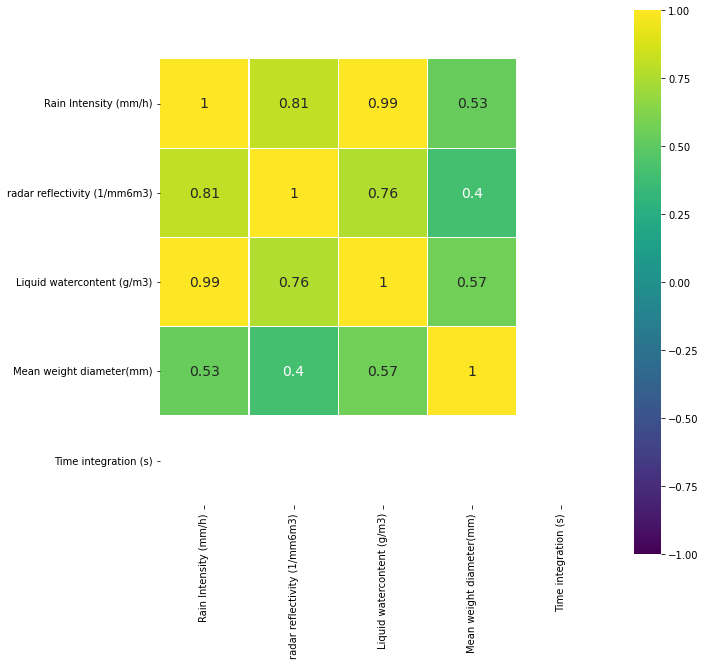

In [18]:
corr = df_rd80_joss.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 14}, square=True);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


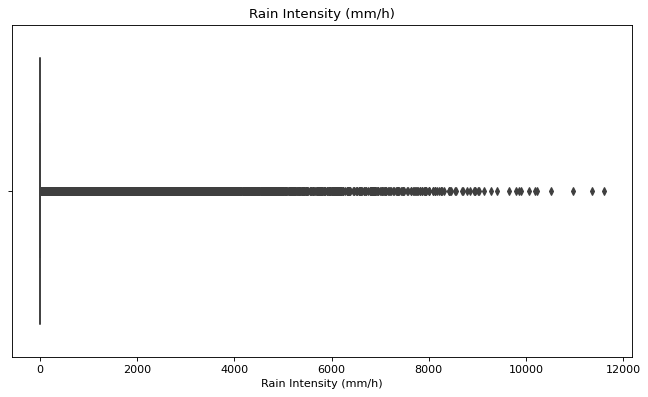

In [26]:
figure(figsize=(10,5.5),dpi=80)
g = sns.boxplot(df_rd80_joss['Rain Intensity (mm/h)'])
g.set_title('Rain Intensity (mm/h)')
plt.show()

[]

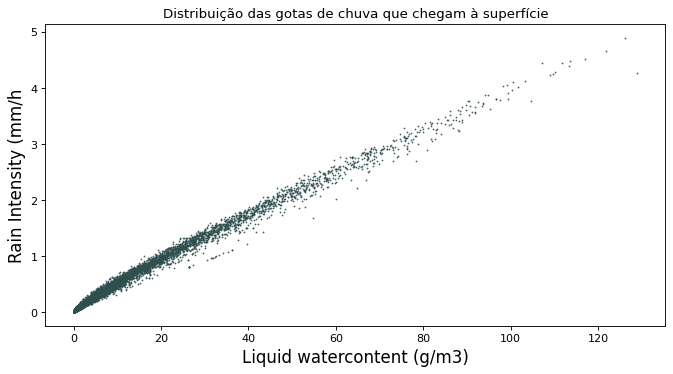

In [23]:
figure(figsize=(10,5),dpi=80)
plt.scatter(df_rd80_joss['Rain Intensity (mm/h)'] ,df_rd80_joss['Liquid watercontent (g/m3)'],s=0.3, color='#2F4F4F')
#plt.xscale('log')
plt.xlabel(r'Liquid watercontent (g/m3)',size=15)
plt.ylabel(r'Rain Intensity (mm/h',size=15)
plt.title("Distribuição das gotas de chuva que chegam à superfície")
plt.plot()

In [ ]:
plt.figure(figsize=(15, 5.5))
g = sns.boxplot(df_rd80_joss['Rain Intensity (mm/h)'])
g.set_title('Rain Intensity (mm/h)')
plt.show()

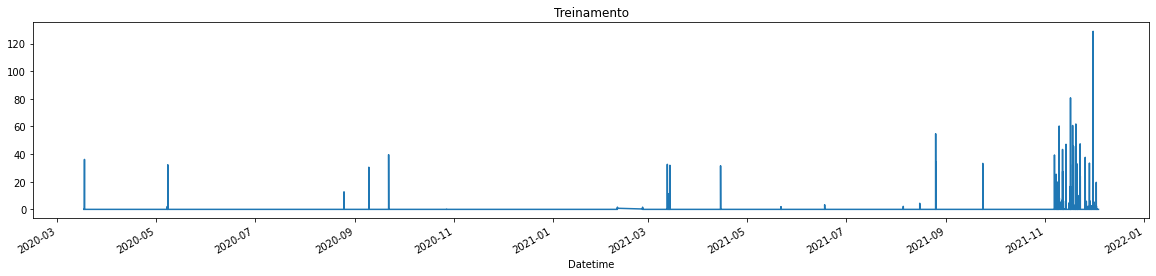

In [481]:
df_train_rd80_joss['Rain Intensity (mm/h)'].plot(figsize = (20,4), title='Treinamento')

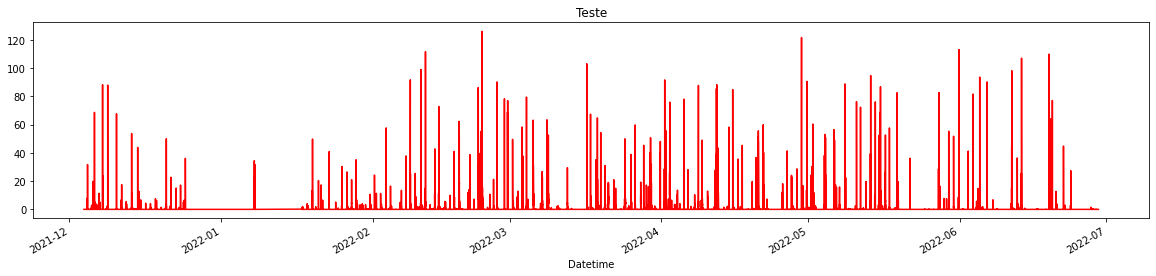

In [482]:
df_val_rd80_joss['Rain Intensity (mm/h)'].plot(figsize = (20,4), title='Teste', color='r')

63084
252336


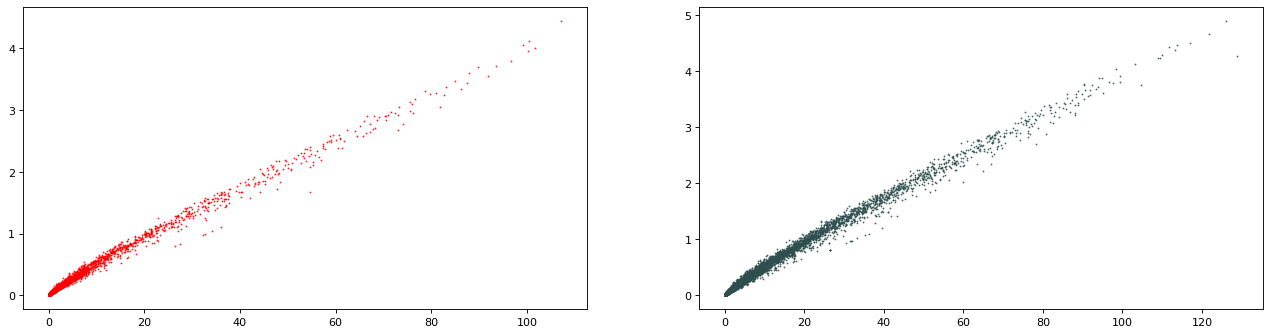

In [29]:
# Divisão do Dataset em treinamento e validação
x_train, x_test, y_train, y_test = train_test_split(df_rd80_joss['Rain Intensity (mm/h)'] ,df_rd80_joss['Liquid watercontent (g/m3)'], test_size=0.8)
print(len(x_train))
print(len(x_test))
figure(figsize=(20,5),dpi=80)
plt.subplot(1,2,1)
plt.scatter(x_train, y_train, color='#FF0000',s=0.3)
plt.subplot(1,2,2)
plt.scatter(x_test, y_test, color='#2F4F4F',s=0.3)
plt.show()

**Modelo 1**

Para tentar construir uma rede capaz de encontrar uma lei de regressão para esses problemas, serão geradas 5 topologias de rede diferentes. O primeiro será o caso simples e clássico de um perceptron e o segundo aumentará o número de camadas e o número de neurônios.

In [30]:
fl2 = 0.0
drop = 0.2

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)
adam = tf.keras.optimizers.Adam()

#modelo_a -- Simple Case
modelo_a = keras.Sequential()
modelo_a.add(keras.layers.Dense(units=3, input_shape=[1], activation="tanh"))
modelo_a.add(keras.layers.Dense(units=1, activation="linear"))
#tf.keras.utils.plot_model(modelo_a, show_shapes=True)

#modelo_b
modelo_b = keras.Sequential()
modelo_b.add(keras.layers.Dense(units=5, input_shape=[1], activation="tanh"))
modelo_b.add(keras.layers.Dense(units=5, activation="tanh"))
modelo_b.add(keras.layers.Dense(units=1, activation="linear"))
#tf.keras.utils.plot_model(modelo_b, show_shapes=True)

#modelo_c
modelo_c = keras.Sequential()
modelo_c.add(keras.layers.Dense(units=5, input_shape=[1], activation="tanh"))
modelo_c.add(keras.layers.Dense(units=5, activation="tanh"))
modelo_c.add(keras.layers.Dense(units=1, activation="linear"))
#tf.keras.utils.plot_model(modelo_c, show_shapes=True)

#model - Suposto para ser o último e mais poderoso modelo
model = keras.Sequential()
model.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model.add(Dropout(drop))
model.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
model.add(Dropout(drop))
model.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
model.add(Dropout(drop))
model.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
model.add(Dropout(drop))
model.add(keras.layers.Dense(units=50, kernel_regularizer=l2(fl2), activation="tanh"))
model.add(keras.layers.Dense(units=20, kernel_regularizer=l2(fl2), activation="sigmoid"))
model.add(keras.layers.Dense(units=50, activation="linear"))
#tf.keras.utils.plot_model(model, show_shapes=True)

**Compilando os Modelos criados**

In [31]:
modelo_a.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])
modelo_b.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])
modelo_c.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

**Agora vamos treinar os Modelos**

In [36]:
epocas = 5 #Degine a quantidade de épocas para o treinamento

early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_modelo_a = modelo_a.fit(x_train, y_train, epochs=epocas, batch_size=10, validation_split=0.2, verbose=True) #callbacks=[early])
history_modelo_b = modelo_b.fit(x_train, y_train, epochs=epocas, batch_size=10, validation_split=0.2, verbose=True) #callbacks=[early])
history_modelo_c = modelo_c.fit(x_train, y_train, epochs=epocas, batch_size=10, validation_split=0.2, verbose=True) #callbacks=[early])
history_model = model.fit(x_train, y_train, epochs=epocas, batch_size=10, validation_split=0.2, verbose=True) #callbacks=[early])

Epoch 1/5
5047/5047 [==============================] - 14s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0062 - val_loss: 0.0010 - val_mean_absolute_error: 0.0061
Epoch 2/5
5047/5047 [==============================] - 14s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0065 - val_loss: 5.2892e-04 - val_mean_absolute_error: 0.0035
Epoch 3/5
5047/5047 [==============================] - 13s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0053 - val_loss: 0.0052 - val_mean_absolute_error: 0.0127
Epoch 4/5
5047/5047 [==============================] - 14s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0064 - val_loss: 5.4630e-04 - val_mean_absolute_error: 0.0039
Epoch 5/5
5047/5047 [==============================] - 13s 3ms/step - loss: 0.0025 - mean_absolute_error: 0.0059 - val_loss: 3.9449e-04 - val_mean_absolute_error: 0.0024
Epoch 1/5
5047/5047 [==============================] - 18s 3ms/step - loss: 0.0076 - mean_absolute_error: 0.0138 - val_loss: 0.0055 - val_mean_absolute_error:

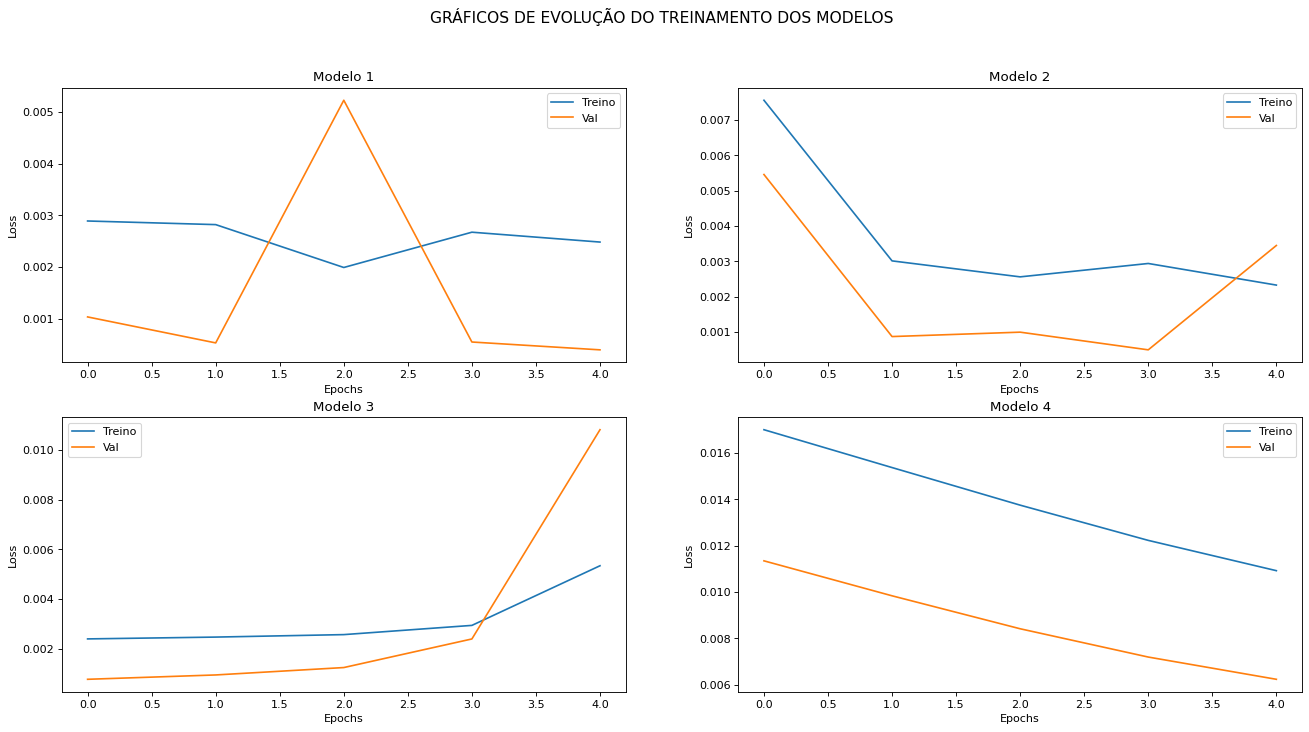

In [79]:
from numpy.core.fromnumeric import size
figure(figsize=(20,10),dpi=80)
plt.suptitle('GRÁFICOS DE EVOLUÇÃO DO TREINAMENTO DOS MODELOS', size=14)

plt.subplot(2,2,1)
plt.title('Modelo 1')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_modelo_a.history['loss'], label="Treino")
plt.plot(history_modelo_a.history['val_loss'], label="Val")
plt.legend()


plt.subplot(2,2,2)
plt.title('Modelo 2')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_modelo_b.history['loss'], label="Treino")
plt.plot(history_modelo_b.history['val_loss'], label="Val")
plt.legend()


plt.subplot(2,2,3)
plt.title('Modelo 3')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_modelo_c.history['loss'], label="Treino")
plt.plot(history_modelo_c.history['val_loss'], label="Val")
plt.legend()


plt.subplot(2,2,4)
plt.title('Modelo 4')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_model.history['loss'], label="Treino")
plt.plot(history_model.history['val_loss'], label="Val")
plt.legend()
plt.show()



**Avaliação (teste)**

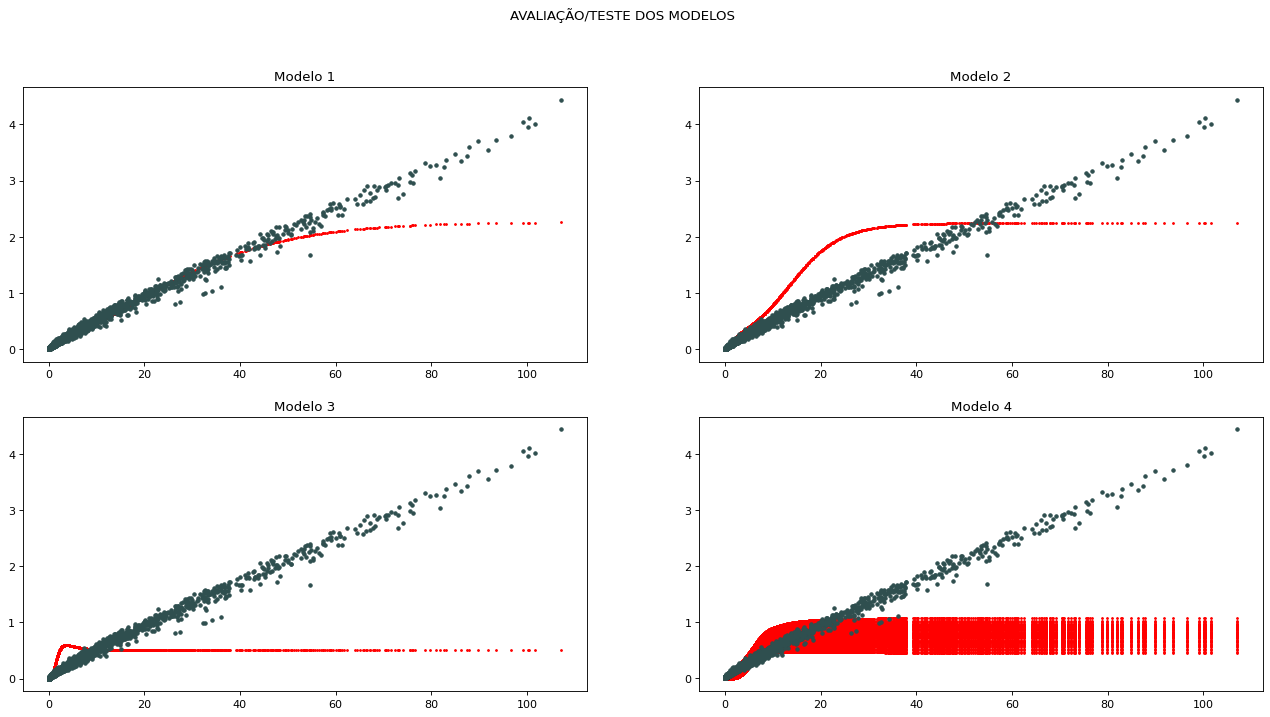

In [81]:
figure(figsize=(20,10),dpi=80)
plt.suptitle('AVALIAÇÃO/TESTE DOS MODELOS')

plt.subplot(2,2,1)
y_rest = modelo_a.predict(x_train)
plt.plot(x_train, y_rest, '.', markersize=3 ,color='#FF0000')
plt.plot(x_train, y_train, '.', color='#2F4F4F')
plt.title('Modelo 1')

plt.subplot(2,2,2)
y_rest = modelo_b.predict(x_train)
plt.plot(x_train, y_rest, '.', markersize=3 ,color='#FF0000')
plt.plot(x_train, y_train, '.', color='#2F4F4F')
plt.title('Modelo 2')

plt.subplot(2,2,3)
y_rest = modelo_c.predict(x_train)
plt.plot(x_train, y_rest, '.', markersize=3 ,color='#FF0000')
plt.plot(x_train, y_train, '.', color='#2F4F4F')
plt.title('Modelo 3')

plt.subplot(2,2,4)
y_rest = model.predict(x_train)
plt.plot(x_train, y_rest, '.', markersize=3 ,color='#FF0000')
plt.plot(x_train, y_train, '.', color='#2F4F4F')
plt.title('Modelo 4')


plt.show()

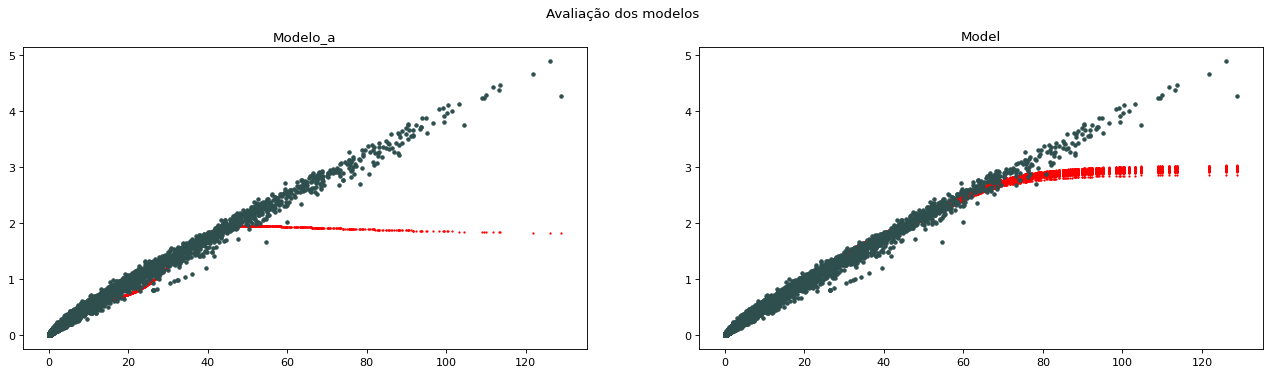

7886/7886 [==============================] - 15s 2ms/step - loss: 3.6598e-04 - mean_absolute_error: 0.0054


In [507]:
figure(figsize=(20,5),dpi=80)
plt.suptitle('Avaliação dos modelos')
plt.subplot(1,2,1)
y_res = modelo_a.predict(x_test)
plt.plot(x_test, y_res, '.', markersize=2, color='#FF0000')
plt.plot(x_test, y_test, '.', color='#2F4F4F')
plt.title('Modelo_a')

plt.subplot(1,2,2)
y_res = model.predict(x_test)
plt.plot(x_test, y_res, '.', markersize=2, color='#FF0000')
plt.plot(x_test, y_test, '.', color='#2F4F4F')
plt.title('Model')


plt.show()

test_loss = modelo_a.evaluate(x_test, y_test)
test_loss = model.evaluate(x_test, y_test)

In [509]:
score_modelo_a = modelo_a.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score_modelo_a[0])
print("Test metric:", score_modelo_a[1])
print("\n\n")
score_model = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score_model[0])
print("Test metric:", score_model[1])

Test loss: 0.0018180832266807556
Test metric: 0.007524958811700344



Test loss: 0.00036598293809220195
Test metric: 0.005357616115361452
